In [1]:
import pyvisa as visa
import time
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit as cf

In [5]:
rm = visa.ResourceManager()

In [14]:
rm.list_resources()

('ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'GPIB0::22::INSTR',
 'GPIB0::23::INSTR',
 'GPIB0::24::INSTR',
 'GPIB0::25::INSTR')

In [18]:
fuente=rm.open_resource('GPIB0::25::INSTR')
print(fuente.query('*IDN?'))

mult_1=rm.open_resource('GPIB0::24::INSTR')
print(mult_1.query('*IDN?'))

mult_2=rm.open_resource('GPIB0::23::INSTR')
print(mult_2.query('*IDN?'))

mult_3=rm.open_resource('GPIB0::22::INSTR')
print(mult_3.query('*IDN?'))

Agilent Technologies,B2901A,MY51140178,1.0.1121.1140

HEWLETT-PACKARD,34401A,0,11-5-2

HEWLETT-PACKARD,34401A,0,7-5-2

HEWLETT-PACKARD,34401A,0,7-5-2



In [19]:
def set_corriente(I,V_max):
    fuente.write(':OUTP ON')
    fuente.write(':SOUR:FUNC:MODE CURR')
    fuente.write(f':SENS:VOLT:PROT {V_max}')
    fuente.write(f':SOUR:CURR {I}')

def set_voltaje(V,I_max):
    fuente.write(':OUTP ON')
    fuente.write(':SOUR:FUNC:MODE VOLT')
    fuente.write(f':SENS:CURR:PROT {I_max}')
    fuente.write(f':SOUR:VOLT {V}')

def medir_voltaje1():
    return float(mult_1.query('MEASURE:VOLTAGE:DC?'))

def medir_voltaje2():
    return float(mult_2.query('MEASURE:VOLTAGE:DC?'))

def medir_voltaje3():
    return float(mult_3.query('MEASURE:VOLTAGE:DC?'))

In [316]:
medir_voltaje3()

5.3083e-05

In [22]:
def medir_t(t_f,t0=0):
    t = [t0]
    t_f += t0
    V1 = [0]
    V2 = [0]
    while t[-1] < t_f:
        t_start = time.time()
        V1.append(medir_voltaje1())
        V2.append(medir_voltaje2())
        t_end = time.time()
        t.append(t[-1]+t_end-t_start)
    a = np.array([t,V1,V2]).transpose()
    df = pd.DataFrame(a[1:],columns=['t','V1','V2'])
    return df

def medir3_t(t_f,t0=0):
    t = [t0]
    t_f += t0
    V1 = [0]
    V2 = [0]
    V3 = [0]
    while t[-1] < t_f:
        t_start = time.time()
        V1.append(medir_voltaje1())
        V2.append(medir_voltaje2())
        V3.append(medir_voltaje3())
        t_end = time.time()
        t.append(t[-1]+t_end-t_start)
    a = np.array([t,V1,V2,V3]).transpose()
    df = pd.DataFrame(a[1:],columns=['t','V1','V2','V3'])
    return df

In [23]:
from tc import Thermocouple

In [24]:
termoloco = Thermocouple()

temp = lambda V : termoloco.mv_to_typek(V*1000)

def temps(Vs):
    Ts = []
    for V in Vs:
        Ts.append(temp(V))
    return np.array(Ts)

In [26]:
temps([0.0002244,0.000255])

array([5.63008211, 6.39760436])

In [290]:
set_corriente(1.5,5)
#time.sleep(100)
#fuente.write(':OUTP OFF')
df = medir3_t(500)
df.to_csv('.csv')

In [109]:
prueba = np.array([1,2,3])
prueba =  np.array([*prueba,0])
prueba

array([1, 2, 3, 0])

In [190]:
currents = np.arange(0.3,1.5,0.3)
print(currents)

t = 0
t_s = time.time()
for I in currents:     
    set_corriente(I,5)
    t = time.time()-t_s
    df = medir3_t(5,t0=t)
    df.to_csv(f'seebeck/pruebita/{I}.csv')
fuente.write(':OUTP OFF')
t = time.time()
df = medir3_t(5,t0=t-t_s)
df.to_csv('seebeck/pruebita/0.0.csv')

[0.3 0.6 0.9 1.2]


In [241]:
df = pd.read_csv('caract/mults3.csv')
V0_1 = np.mean(df.V1)
V0_2 = np.mean(df.V2)
V0_3 = np.mean(df.V3[df.V3<0.002])
print(V0_1*1000,V0_2*1000,V0_3*1000)

df = pd.read_csv('caract/3cuplas.csv')
df.V1 -= V0_1
df.V2 -= V0_2
df.V3 -= V0_3
Vc_1 = np.mean(df.V1)
Vc_2 = np.mean(df.V2)
Vc_3 = np.mean(df.V3)
dV1 = Vc_1 - Vc_2
dV3 = Vc_3 - Vc_2
print(dV1*1000,dV3*1000)

-0.24237812499999997 -0.005738416666666665 -0.0023332842105263105
0.4045866302083333 0.3296623050438596


In [292]:
df = pd.read_csv('agua/am_500s.csv')
df.V1 -= V0_1
df.V1 -= dV1
df.V2 -= V0_2
df.V3 -= V0_3
df.V3 -= dV3

In [295]:
temp1 = []
temp2 = []
#temp3 = []
for i in range(len(df)):
    temp1.append(temp(df.V1[i]))
    temp2.append(temp(df.V2[i]))
#    temp3.append(temp(df.V3[i]))
temp1 = np.array(temp1)
temp2 = np.array(temp2)
#temp3 = np.array(temp3)

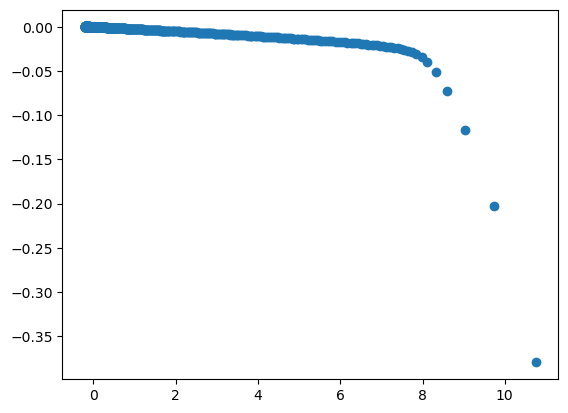

In [289]:
dT = temp2-temp1
plt.scatter(dT,df.V3)
#plt.scatter(dT[dT > -1],df.V3[dT > -1])
#plt.xlabel(r'$\Delta T$ [K]')
#plt.ylabel('V [V]')
#plt.xlim(-7.3,-6.3)
#plt.ylim(-0.03,0)

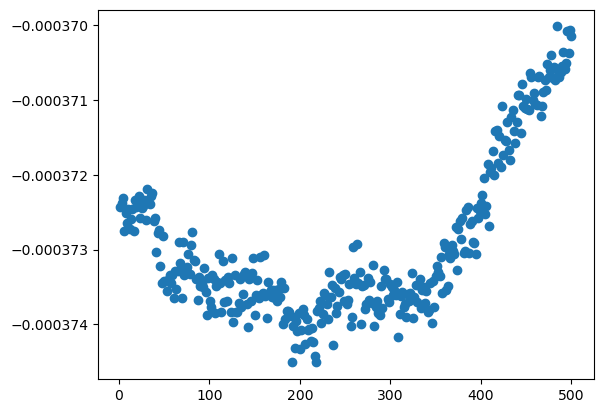

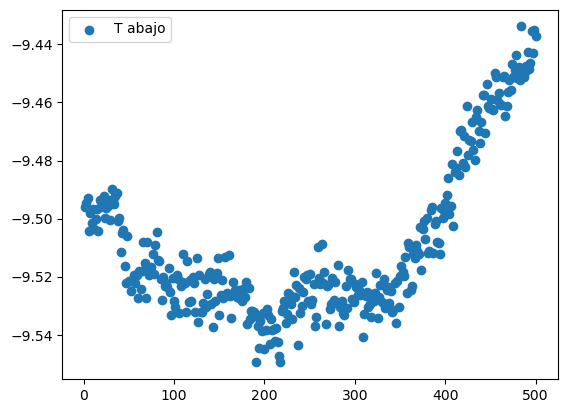

In [298]:
plt.scatter(df.t,df.V1, label='V1')
#plt.scatter(df.t,df.V2, label='V2')
#plt.scatter(df.t,df.V3,label='V3')
#plt.legend()
plt.show()
plt.scatter(df.t,temp1, label='T abajo')
#plt.scatter(df.t,temp2, label='T arriba')
#plt.scatter(df.t,temp3, label='T agua')
plt.legend()
plt.show()
#plt.scatter(df.t,temp2-temp1)
#plt.xlim(-5,-3)
#plt.ylim(-0.001,0.015)

In [166]:
files = os.listdir('seebeck/saltos pos')

names = []
for i in range(len(files)):
    if files[i].endswith('.csv'):
        names.append(float(files[i][:-4]))
names = np.sort(np.array(names))
for i in range(len(names)-1):
    names[i] = names[i+1]
names[-1] = 0.0
print(names)

[0.3 0.6 0.9 1.2 0. ]


In [217]:
df = pd.read_csv(f'seebeck/saltos pos/{names[0]}.csv')
for name in names[1:]:
    df = pd.concat([df,pd.read_csv(f'seebeck/saltos pos/{name}.csv')])

df.drop(columns=df.columns[0],axis=1,inplace=True)
df.reset_index(drop=True,inplace=True)
df.V1 -= V0_1
df.V2 -= V0_2
df.V1 -= dV

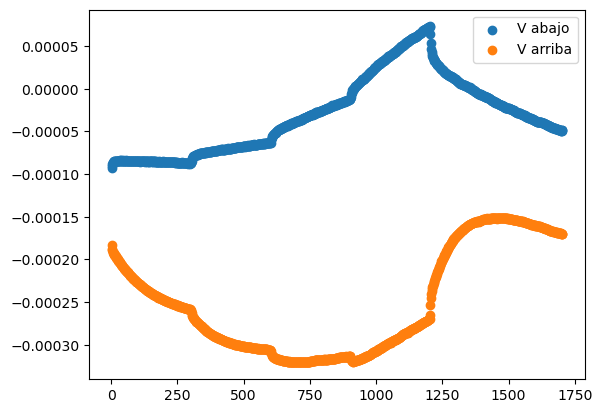

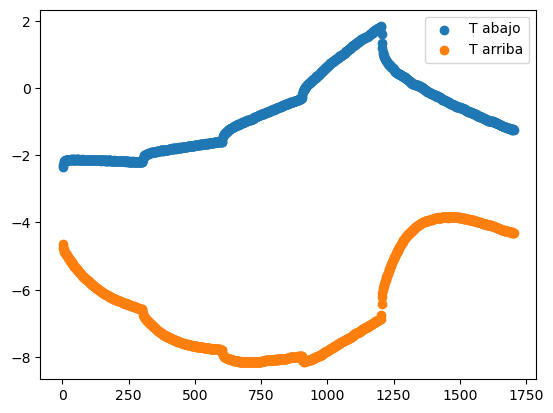

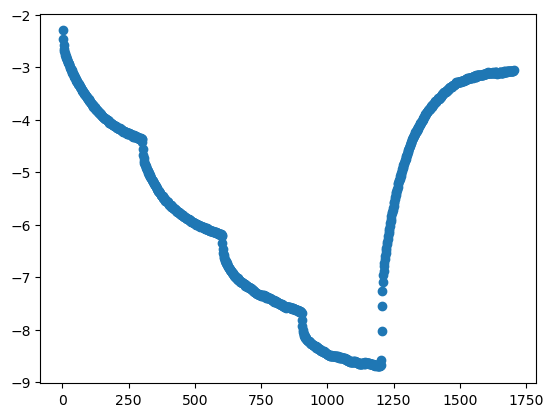

In [218]:
temp1 = temps(df.V1)
temp2 = temps(df.V2)

plt.scatter(df.t,df.V1, label='V abajo')
plt.scatter(df.t,df.V2, label='V arriba')
plt.legend()
plt.show()
plt.scatter(df.t,temp1, label='T abajo')
plt.scatter(df.t,temp2, label='T arriba')
plt.legend()
plt.show()
plt.scatter(df.t,temp2-temp1)